In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from functions import *
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from sklearn.utils import shuffle
from IPython.display import HTML

%matplotlib inline

In [3]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

## Read File names recursivley

In [4]:
vehicle_glob = glob.iglob('train/vehicles/**/*.png', recursive=True)
nonvehicle_glob = glob.iglob('train/non-vehicles/**/*.png', recursive=True)

cars = []
notcars = []
for file in vehicle_glob:
    cars.append(file)
for file in nonvehicle_glob:
    notcars.append(file)

## Randomly plot images

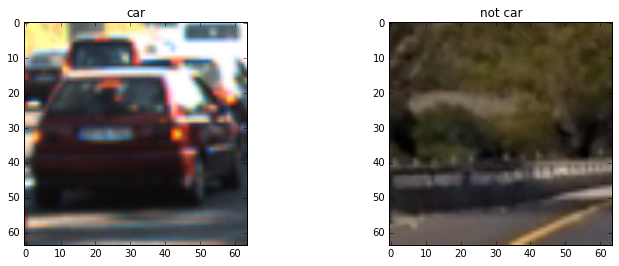

In [5]:
car_ind = np.random.randint(0, len(cars))


f, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.imshow(mpimg.imread(cars[car_ind]));
ax1.set_title("car");
ax2.imshow(mpimg.imread(notcars[car_ind]));
ax2.set_title("not car");
#plt.imshow(mpimg.imread(cars[car_ind]))

## Feature Extraction

In [6]:

### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

## Data Preprocessing

In [7]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

scaled_X , y = shuffle(scaled_X, y)

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2)

## Training

### SVM

In [8]:
svc = LinearSVC()
svc.fit(X_train, y_train)
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Test Accuracy of SVC =  0.9896


### Neural Network

In [8]:
from keras.models import *
from keras.layers import *
from keras.layers import Flatten, Activation, Dense
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

nb_classes = 2

y_train_one_hot = np_utils.to_categorical(y_train, nb_classes)
y_test_one_hot = np_utils.to_categorical(y_test, nb_classes)

model = Sequential()

model.add(Dense(32, input_shape=(X_train.shape[1],)))
model.add(Dropout(0.3))
model.add(Activation('relu'))
model.add(Dense(2**12))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile('adam', 'categorical_crossentropy', ['accuracy'])

print("starting training model")
history = model.fit(X_train, y_train_one_hot,
                    shuffle=True,
                    batch_size=32,
                    nb_epoch= 3, 
                    validation_split=0.2,
                    verbose=1)

# plt.plot(list(history.history['acc']), color = 'b')
# plt.plot(list(history.history['val_acc']), color = 'g')

metrics = model.evaluate(X_test, y_test_one_hot)
for metric_i in range(len(model.metrics_names)):
    metric_name = model.metrics_names[metric_i]
    metric_value = metrics[metric_i]
    print('{}: {}'.format(metric_name, metric_value))

Using TensorFlow backend.


starting training model
Train on 11366 samples, validate on 2842 samples
Epoch 1/3
11366/11366 [==============================] - 3s - loss: 0.1144 - acc: 0.9693 - val_loss: 0.0521 - val_acc: 0.9898

## Predictions

In [12]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    box_list = []
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64 
    nblocks_per_window = (window // pix_per_cell)-1 
    
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
   
#     nxblocks 63
#     window 64
#     nblocks_per_window 7
#     cells_per_step 2
#     nxsteps 28

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
            
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
                        
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)) 
            #test_features = X_scaler.transform(np.hstack(spatial_features).reshape(1, -1)) 
            test_prediction = svc.predict(test_features)
            #test_prediction = model.predict_classes(test_features ,verbose=0)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                
                box_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
    
    plt.imshow(draw_img)
    return box_list

def draw_bboxes(img, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        cv2.rectangle(img, (box[0][0], box[0][1]), (box[1][0], box[1][1]), (0,0,255), 6) 
    
    return img

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [13]:
def process(img):

    box_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    # Read in image similar to one shown above 
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat, box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)

    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img

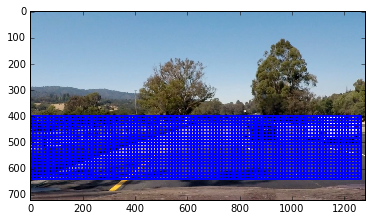

In [15]:
ystart = 400
ystop = 656
scale = 1.5

#f, ax1 = plt.subplots(7, sharex=True ,sharey=True, figsize=(10,30))
images = glob.glob('./test_images/test*.jpg')
for idx, fname in enumerate(images):
    img = mpimg.imread(fname)
    draw_img = process(img)
    break
    ax1[idx].imshow(draw_img)
    ax1[idx].set_title(fname)
    #plt.imshow(draw_img)
# f, (ax1, ax2) = plt.subplots(2,2, sharex=True ,sharey=True, figsize=(8,8))
# img = mpimg.imread('test_images/test1.jpg')
# draw_img = process(img)
# ax1[0].imshow(img)
# ax1[0].set_title("test1.jpg")
# img = mpimg.imread('test_images/test1.jpg')
# draw_img = process(img)
# ax1[1].imshow(draw_img, cmap='hot')
# ax1[1].set_title("heat map")
# img = mpimg.imread('test_images/test5.jpg')
# draw_img = process(img)
# ax2[0].imshow(img)
# ax2[0].set_title("test6.jpg")
# img = mpimg.imread('test_images/test5.jpg')
# draw_img = process(img)
# ax2[1].imshow(draw_img, cmap='hot')
# ax2[1].set_title("heat map")
# f.tight_layout()

# img = mpimg.imread('test_images/test7.jpg')
# draw_img = process(img)

# fig = plt.figure(figsize=(10,10))
# plt.imshow(draw_img)

In [33]:
#video_file = 'test_video.mp4'
video_file = 'project_video.mp4'
output_video = 'project_submission.mp4'
clip1 = VideoFileClip(video_file)
output_clip = clip1.fl_image(process)
%time output_clip.write_videofile(output_video, audio=False)
print("clip1.fps=",clip1.fps)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))

[MoviePy] >>>> Building video project_submission.mp4
[MoviePy] Writing video project_submission.mp4


100%|█████████▉| 1260/1261 [13:14<00:00,  1.62it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_submission.mp4 

CPU times: user 14min 25s, sys: 9.89 s, total: 14min 34s
Wall time: 13min 15s
clip1.fps= 25.0


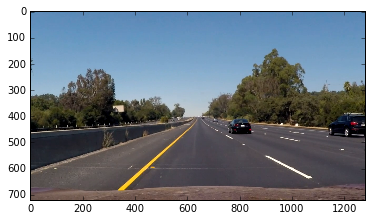

In [20]:
test_image = clip1.get_frame('00:50:00')
plt.imsave("test_images/test7.jpg", test_image )
plt.imshow(test_image)